In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix,precision_score,recall_score
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define data transformations ( optional , but recommended )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root ='./data ', train = True, transform = transform, download =True)
print(train_dataset)

100%|██████████| 170498071/170498071 [00:08<00:00, 20887064.98it/s]


Extracting ./data /cifar-10-python.tar.gz to ./data 
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [4]:
# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root ='./data ', train = False, transform = transform, download =True)
print(test_dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data 
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


100%|██████████| 170498071/170498071 [00:08<00:00, 20653144.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
[1,  2000] loss: 2.353
[1,  4000] loss: 2.030
[1,  6000] loss: 1.927
[2,  2000] loss: 1.797
[2,  4000] loss: 1.719
[2,  6000] loss: 1.703
[3,  2000] loss: 1.619
[3,  4000] loss: 1.590
[3,  6000] loss: 1.545
[4,  2000] loss: 1.466
[4,  4000] loss: 1.465
[4,  6000] loss: 1.470
[5,  2000] loss: 1.389
[5,  4000] loss: 1.366
[5,  6000] loss: 1.368
[6,  2000] loss: 1.295
[6,  4000] loss: 1.264
[6,  6000] loss: 1.290
[7,  2000] loss: 1.216
[7,  4000] loss: 1.192
[7,  6000] loss: 1.184
[8,  2000] loss: 1.131
[8,  4000] loss: 1.113
[8,  6000] loss: 1.111
[9,  2000] loss: 1.060
[9,  4000] loss: 1.064
[9,  6000] loss: 1.050
[10,  2000] loss: 0.985
[10,  4000] loss: 0.975
[10,  6000] loss: 0.988
[11,  2000] loss: 0.929
[11,  4000] loss: 0.948
[11,  6000] loss: 0.920
[12,  2000] loss: 0.839
[12,  4000] loss: 0.877
[12,  6000] loss: 0.883
[13,  2000] loss: 0.790
[13,  4000] loss: 0.809
[13,  6000] loss: 0.836
[14,  2000] loss: 0.763
[14,  4000] loss

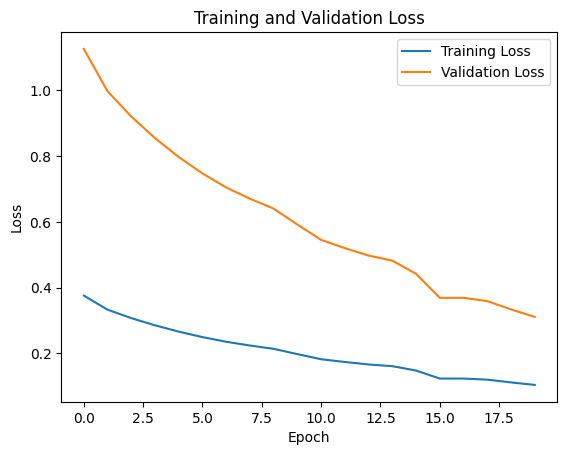

In [6]:
# Load the CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Define the ratios
train_ratio = 0.6
val_ratio = test_ratio = 0.2

# Calculate the lengths
total = len(dataset)
train_len = int(train_ratio * total)
val_len = int(val_ratio * total)
test_len = total - train_len - val_len

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Define the CNN model
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = torchvision.models.resnet152(zero_init_residual=True)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(2048, 10)
        

    def forward(self, x):
        features = self.encoder(x)
        features_np = features# Convert to numpy array

        return self.fc(features_np)
      

net = Net()
net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the network
train_losses = []
val_losses = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
       
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    train_losses.append(running_loss / len(trainloader))
    val_losses.append(running_loss / len(valloader))

print('Finished Training')

# Test the network on the test data
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in testloader:
        
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())  # move labels back to CPU
        all_predictions.extend(predicted.cpu().numpy())

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Calculate confusion matrix, precision and recall
cm = confusion_matrix(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
print('Confusion Matrix:', cm)
print('Precision:', precision)
print('Recall:', recall)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Evaluate the model on the test dataset
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in testloader:
        
        images, labels = data[0].to(device), data[1].to(device) 
        #images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels)
        all_predictions.extend(predicted)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 68 %
